In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import misc
import tensorflow as tf
import utils
import time
import timeit

## Settings

In [21]:
FROZEN_FPATH = 'data/frozen.pb' # ADJUST
INPUTE_NODE = 'net/input:0' # ADJUST
OUTPUT_NODE = 'net/fc8/BiasAdd:0' # ADJUST
CLASSES = ['Cat', 'Dog'] # ADJUST
CROP_SIZE = (224, 224) # ADJUST

## Load frozen graph and create TF session

In [22]:
graph_def = tf.GraphDef()
with tf.gfile.GFile(FROZEN_FPATH, "rb") as f:    
    graph_def.ParseFromString(f.read())
    
graph = tf.Graph()
with graph.as_default():
    net_inp, net_out = tf.import_graph_def(
        graph_def, return_elements=[INPUTE_NODE, OUTPUT_NODE])
    
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=sess_config)

## Load and preapre input image

/home/amax/.local/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/home/amax/.local/lib/python2.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if sys.path[0] == '':


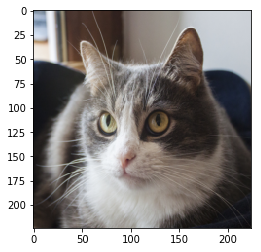

In [39]:
INPUT_IMAGE_FPATH = 'img/image.png'
# INPUT_IMAGE_FPATH = 'imagenet/val/ILSVRC2012_val_00004422.JPEG'
# INPUT_IMAGE_FPATH = 'imagenet/val/ILSVRC2012_val_00002708.JPEG'

def prepare_image(img_in, crop_size):
    img = img_in.astype(np.float32)
    img = utils.resize_and_crop(img, crop_size)
    img = img[None, ...]
    return img

img = scipy.misc.imread(INPUT_IMAGE_FPATH, mode='RGB')
img = misc.imresize(img, CROP_SIZE, mode='RGB')
img = img[None, ...]
#img = prepare_image(img, CROP_SIZE)
_=plt.imshow(img[0, ...]/255.)


## Run inference

In [40]:
out = sess.run(net_out, feed_dict={net_inp: img})

print('Prediction: {}'.format(CLASSES[np.argmax(out)]))

Prediction: Cat


## Calculate validation accuracy

In [66]:
import data_provider
image_list, label_list = data_provider.prepare_sample_list(
        '/data/ImageNet/val/','val.txt',classes=[281, 239])

correct = 0
for img_fpath, label in zip(image_list, label_list):
    img = scipy.misc.imread(img_fpath, mode='RGB')
    #img = prepare_image(img, CROP_SIZE)
    img = misc.imresize(img, CROP_SIZE, mode='RGB')
    img = img[None, ...]
    st = time.time()
    out = sess.run(net_out, feed_dict={net_inp: img})
    print str((time.time()-st)*1000) +  ' ms' 
    if np.argmax(out) == label:
        correct += 1
        
accuracy = float(correct) / len(image_list)
print('Accuracy: {}'.format(accuracy))

/home/amax/.local/lib/python2.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys
/home/amax/.local/lib/python2.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':


5.31411170959 ms
5.16510009766 ms
5.24306297302 ms
5.21492958069 ms
5.3699016571 ms
5.18107414246 ms
5.18703460693 ms
5.206823349 ms
5.23900985718 ms
5.13815879822 ms
5.11193275452 ms
5.2011013031 ms
5.18298149109 ms
5.12003898621 ms
5.22208213806 ms
5.16605377197 ms
5.20491600037 ms
5.15484809875 ms
5.19704818726 ms
5.13696670532 ms
5.34987449646 ms
5.20086288452 ms
5.08999824524 ms
5.13315200806 ms
5.13792037964 ms
5.25403022766 ms
5.13911247253 ms
5.07211685181 ms
5.07783889771 ms
5.15484809875 ms
5.10621070862 ms
5.11002540588 ms
5.17582893372 ms
5.16700744629 ms
5.17797470093 ms
5.16319274902 ms
5.17296791077 ms
5.12790679932 ms
5.10501861572 ms
5.14578819275 ms
5.14101982117 ms
5.10096549988 ms
5.15389442444 ms
5.15699386597 ms
5.11384010315 ms
5.10716438293 ms
5.14602661133 ms
5.16295433044 ms
5.14698028564 ms
5.06901741028 ms
5.11193275452 ms
5.12480735779 ms
5.15484809875 ms
5.12099266052 ms
5.10215759277 ms
5.17201423645 ms
5.17320632935 ms
5.09095191956 ms
5.13291358948 ms
5

## Measure execution time

In [57]:
%timeit -n 10 -r 10 out = sess.run(net_out, feed_dict={net_inp: img})

#timeit.repeat(stmt='sess.run(net_out, feed_dict={net_inp: img})', repeat=10, number=10)

10 loops, best of 10: 5.33 ms per loop


In [55]:
setup = '''
import tensorflow as tf
graph_def = tf.GraphDef()
with tf.gfile.GFile(FROZEN_FPATH, "rb") as f:    
    graph_def.ParseFromString(f.read())
    
graph = tf.Graph()
with graph.as_default():
    net_inp, net_out = tf.import_graph_def(
        graph_def, return_elements=[INPUTE_NODE, OUTPUT_NODE])
    
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=sess_config)
'''

timeit.repeat(stmt='out=sess.run(net_out, feed_dict={net_inp: img})', setup=setup, repeat=10, number=10)

NameError: global name 'FROZEN_FPATH' is not defined